# Quantum Autoencoder

## Encoder Types

### Classical Encoders
Encode or compress classical data into smaller-sized data via a deterministic algorithm. For example, JPEG is essentially an algorithm that compresses images into smaller-sized images.

### Classical Autoencoders
Use machine-learning techniques and train a variational network for compressing data. In general, an autoencoder network looks as follows:

<center>
<img src="https://docs.classiq.io/resources/Autoencoder_structure.png" style="width:50%">
<figcaption align = "middle"> Classical autoencoder layout (from Wikipedia) </figcaption>
</center>

The network has three main parts: 

1. The encoder compresses the data into a smaller, coded layer. 
2. The latter is the input to a decoder part. 
3. Typically, training is done against the comparison between the input and the output of this network.

**Classical autoencoders can also be used for anomaly detection (see below).**

### Quantum Autoencoders
In a similar fashion to the classical counterpart, a quantum autoencoder compresses quantum data stored initially on $n$ qubits into a smaller quantum register of $m<n$ qubits via a variational circuit. However, quantum computing is reversible; therefore, qubits cannot be "erased". Alternatively, a quantum autoencoder tries to achieve the following transformation from an uncoded quantum register of size $n$ to a coded one of size $m$:
$$
|\psi\rangle_n \rightarrow |\psi'\rangle_m|0\rangle_{n-m}
$$
Namely, we try to decouple the initial state to a product state of a smaller register of size $m$ and a register that is in the zero state. The former is usually called the *coded* state and the latter the *trash* state.

## Training Quantum Autoencoders

To train a quantum autoencoder, we define a proper cost function. Below are two common approaches, one using a swap test and the other using Hamiltonian measurements. We focus on the swap test case, and comment on the other approach at the end of this notebook.

### The Swap Test

The swap test is a quantum function that checks the overlap between two quantum states. The inputs of the function are two quantum registers of the same size, $|\psi_1\rangle, \,|\psi_2\rangle$, and it returns as output a single "test" qubit whose state encodes the overlap between the two inputs: $|q\rangle_{\rm test} = \alpha|0\rangle + \sqrt{1-\alpha^2}|1\rangle$, with
$$
\alpha^2 = \frac{1}{2}\left(1+|\langle \psi_1 |\psi_2 \rangle |^2\right).
$$
Thus, the probability to measure the test qubit at state $0$ is 1 if the states are identical (up to a global phase) and 0 if the states are orthogonal to each other. The quantum model starts with an H gate on the test qubit, followed by swapping between the two states controlled on the test qubit and a final H gate on the test qubit.

### Quantum Neural Networks for Quantum Autoencoders

The quantum autoencoder can be built as a quantum neural network with these parts:

1. A data loading block that loads classical data on $n$ qubits.
2. An encoder block, which is a variational quantum ansatz with input port of size $n$ and output ports of size $m$ and $n-m$.
3. A swap test block between the $n-m$ trash output of the encoder and new $n-m$ zero registers.

We train the network such that the test qubit of the swap test is at state |0⟩ with probability 1.
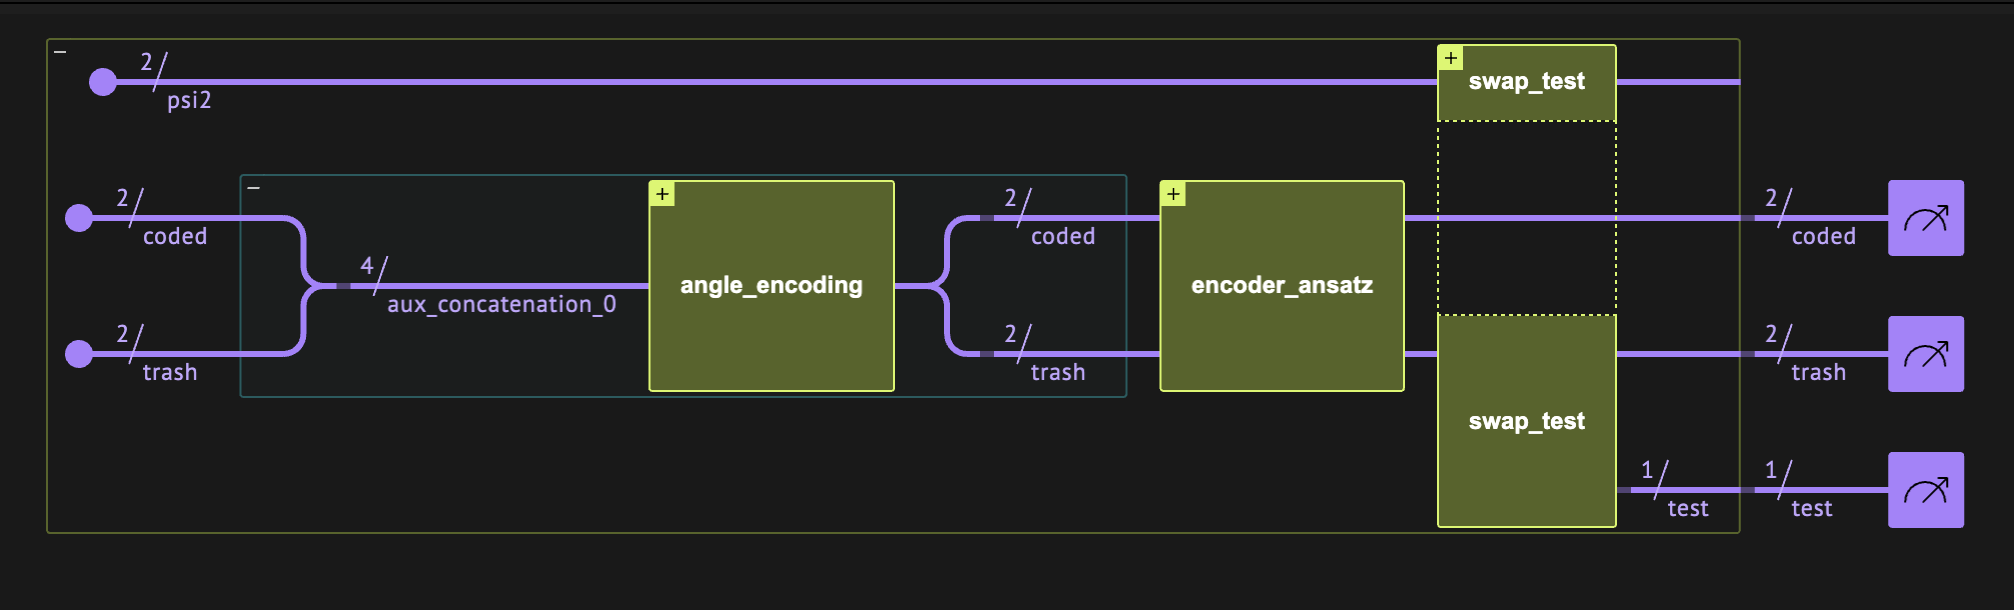
<center>
<figcaption align = "middle">  Quantum autoencoder layout: uncoded data of size 4 transforms into two outputs, a coded register of size 2 and trash outputs of size 2 at state $|00\rangle$
</figcaption>
</center>

## Predefined Functions That Construct the Quantum Layer

In the first step we build user-defined functions that allow flexible modeling:

1. `angle_encoding`: This function loads data of size num_qubits on num_qubits qubits via RY gates.
2. `encoder_ansatz` : A simple variational ansatz for encoding num_qubits qubits on num_encoding_qubits qubits (see the description in the code block).

In [1]:
!pip install -qq -U "classiq[qml]"

In [2]:
from classiq import *
from classiq.qmod.symbolic import pi

In [3]:
@qfunc
def angle_encoding(exe_params: CArray[CReal], qbv: QArray) -> None:
    repeat(
        count=exe_params.len,
        iteration=lambda index: RY(pi * exe_params[index], qbv[index]),
    )

In [4]:
@qfunc
def encoder_ansatz(
    exe_params: CArray[CReal],
    coded: QArray,
    trash: QArray,
) -> None:
    """
    This is a parametric model that acts on num_qubits=trash.len+coded.len qubits.
    It contains trash.len layers, each composed of RY gates and CX gates with a linear connectivity,
    and a final layer with RY gate on each of the trash qubits is applied.
    """

    num_qubits = trash.len + coded.len
    x = QArray()
    within_apply(
        lambda: bind([coded, trash], x),
        lambda: repeat(
            trash.len,
            lambda r: (
                repeat(num_qubits, lambda i: RY(exe_params[r * num_qubits + i], x[i])),
                repeat(num_qubits - 1, lambda i: CX(x[i], x[i + 1])),
            ),
        ),
    )
    repeat(trash.len, lambda i: RY(exe_params[(trash.len) * num_qubits + i], trash[i]))

## Example: Autoencoder for Domain Wall Data

In the following example we try to encode data which has a domain wall structure. Let us define the relevant data for strings of size 4.

### The Data

In [5]:
import numpy as np

domain_wall_data = np.array([[0, 0, 1, 1], [0, 0, 0, 1], [0, 1, 1, 1]])
print("domain wall data:\n", domain_wall_data)

domain wall data:
 [[0 0 1 1]
 [0 0 0 1]
 [0 1 1 1]]


### The Quantum Program

We encode this data of size 4 on 2 qubits. Let us build the corresponding quantum layer based on the predefined functions above:

In [6]:
NUM_QUBITS = 4
NUM_ENCODING_QUBITS = 2
num_trash_qubits = NUM_QUBITS - NUM_ENCODING_QUBITS
num_weights_in_encoder = NUM_QUBITS * num_trash_qubits + num_trash_qubits

We construct the model:

In [7]:
@qfunc
def main(
    w: CArray[CReal, num_weights_in_encoder],
    input_data: CArray[CReal, NUM_QUBITS],
    coded: Output[QArray[NUM_ENCODING_QUBITS]],
    trash: Output[QArray[num_trash_qubits]],
    test: Output[QBit],
) -> None:
    psi2 = QArray()
    allocate(num_trash_qubits, psi2)
    allocate(coded)
    allocate(trash)
    angle_encoding(input_data, [coded, trash])
    encoder_ansatz(
        exe_params=w,
        coded=coded,
        trash=trash,
    )

    swap_test(state1=trash, state2=psi2, test=test)
    drop(psi2)


write_qmod(main, "autoencoder_network")

We synthesize and visualize the quantum layer:

In [8]:
qprog_ae_network = synthesize(main)
show(qprog_ae_network)

Quantum program link: https://platform.classiq.io/circuit/3561eTc4YsmOErGa4GoTroqL0Yz


### The Network

The network for training contains only a quantum layer. The corresponding quantum program was already defined above, so what remains is to define the execution preferences and the classical postprocess. The classical output is defined as $1-\alpha^2$, with $\alpha$ being the probability of the test qubit being at state 0.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from classiq.applications.qnn import QLayer
from classiq.applications.qnn.types import (
    MultipleArguments,
    ResultsCollection,
    SavedResult,
)
from classiq.execution import (
    ExecutionPreferences,
    execute_qnn,
    set_quantum_program_execution_preferences,
)

In [10]:
num_shots = 4096


def execute(
    quantum_program: QuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    quantum_program = set_quantum_program_execution_preferences(
        quantum_program, preferences=ExecutionPreferences(num_shots=num_shots)
    )
    return execute_qnn(quantum_program, arguments)


def post_process(result: SavedResult) -> torch.Tensor:
    alpha_sqaured = result.value.counts_of_output("test").get("0", 0) / num_shots
    out = 1 - alpha_sqaured
    return torch.tensor(out)

In [11]:
def create_net(*args, **kwargs) -> nn.Module:
    class Net(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__()

            self.qlayer = QLayer(
                qprog_ae_network,
                execute,
                post_process,
                *args,
                **kwargs,
            )

        def forward(self, x):
            x = self.qlayer(x)
            return x

    return Net(*args, **kwargs)


encoder_train_network = create_net()

### Creating the Dataset

The cost function to minimize is $|1-\alpha^2|$ for all our training data. Looking at the Qlayer output, this means that we should define the corresponding labels as $0$:

In [12]:
class MyDWDataset:
    def __init__(self, data, labels) -> None:
        self.data = torch.from_numpy(data).float()
        self.labels = torch.unsqueeze(torch.from_numpy(labels), dim=-1).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [13]:
labels = np.array([0, 0, 0])
train_dataset = MyDWDataset(domain_wall_data, labels)
train_data_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, drop_last=False
)

### Defining the Training

In [14]:
import time as time


def train(
    model: nn.Module,
    data_loader: DataLoader,
    loss_func: nn.modules.loss._Loss,
    optimizer: optim.Optimizer,
    epoch: int = 40,
) -> None:
    for index in range(epoch):
        start = time.time()
        for data, label in data_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(torch.squeeze(output), torch.squeeze(label))
            loss.backward()
            optimizer.step()

        print(time.time() - start)
        print(index, f"\tloss = {loss.item()}")

### Setting Hyperparameters

The L1 loss function fits the intended cost function we aim to minimize:

In [15]:
_LEARNING_RATE = 0.3
loss_func = nn.L1Loss()
optimizer = optim.SGD(encoder_train_network.parameters(), lr=_LEARNING_RATE)

### Training

In this demo we initialize the network with trained parameters and run only one epoch for demonstration purposes. Reasonable training with the above hyperparameters can be achieved with $\sim 40$ epochs. To train the network from the beginning, uncomment the following code line:

In [16]:
trained_weights = torch.nn.Parameter(
    torch.Tensor(
        [1.5227, 0.3588, 0.6905, 1.4777, 1.5718, 1.5615, 1.5414, 0.6021, 0.1254, 0.9903]
    )
)
encoder_train_network.qlayer.weight = trained_weights

In [17]:
data_loader = train_data_loader

train(encoder_train_network, data_loader, loss_func, optimizer, epoch=1)

8.214931964874268
0 	loss = 0.000732421875


### Verifying

Once we have trained the network, we can build a new network with the trained variables. We verify our encoder by taking only the encoding block, changing the postprocess, etc. 
Below, we verify our quantum autoencoder by comparing the input with the output of an encoder-decoder network.

We create the following network containing three quantum blocks:
* The first two blocks of the previous network: a block for loading the inputs followed by our quantum encoder.
* We reset the trash qubits, assigning them to be at the zero state explicitly.
* The inverse of the quantum encoder.

**The network weights are allocated with the trained ones.**

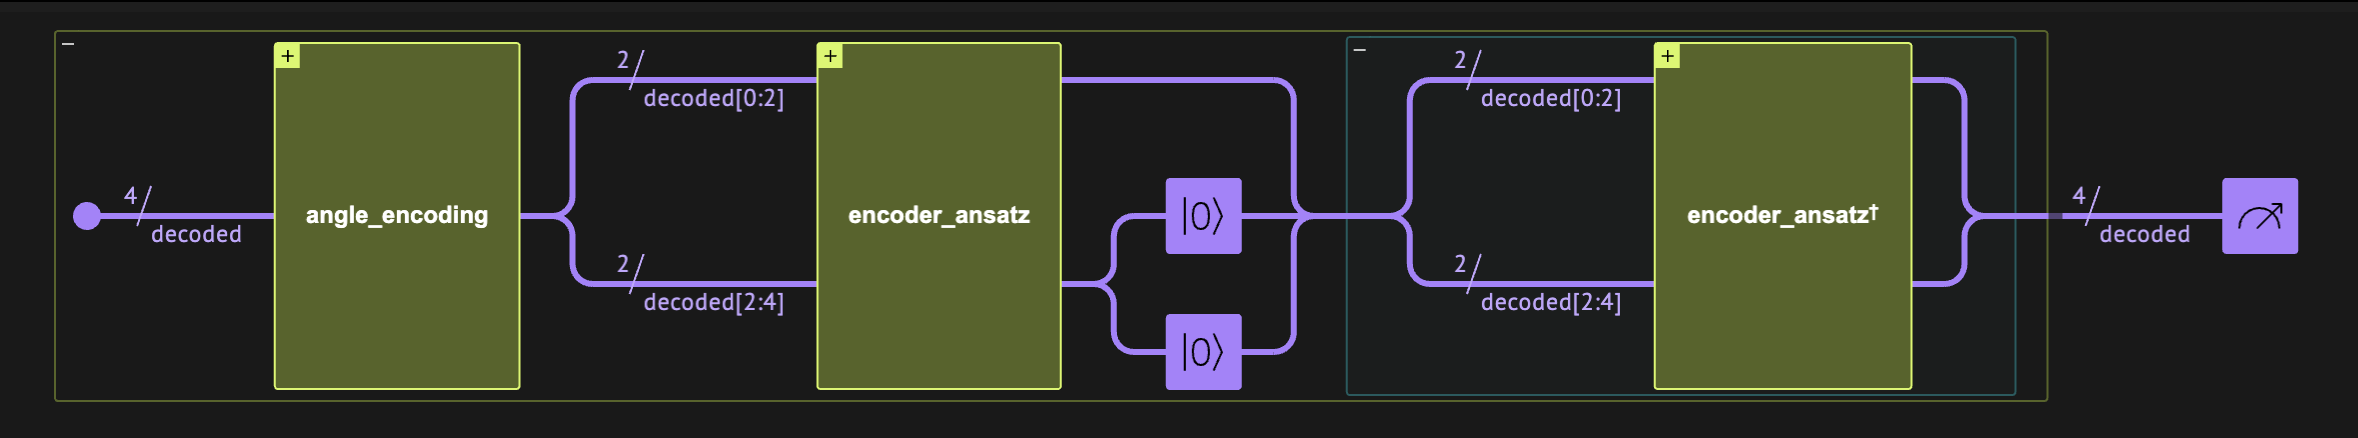
<center>
<figcaption align = "middle"> Qlayer for verifying the quantum autoencoder containing three quantum blocks: (1) data encoding, (2) trained encoder, and (3) inverse of trained encoder (i.e., decoder) </figcaption>
</center>

### Building the Quantum Validator

In [18]:
@qfunc
def main(
    w: CArray[CReal, num_weights_in_encoder],
    input_data: CArray[CReal, NUM_QUBITS],
    decoded: Output[QArray[NUM_QUBITS]],
) -> None:

    allocate(decoded)
    angle_encoding(input_data, decoded)
    encoder_ansatz(
        exe_params=w,
        coded=decoded[0:NUM_ENCODING_QUBITS],
        trash=decoded[NUM_ENCODING_QUBITS:NUM_QUBITS],
    )
    repeat(num_trash_qubits, lambda i: RESET(decoded[NUM_ENCODING_QUBITS + i]))
    invert(
        lambda: encoder_ansatz(
            exe_params=w,
            coded=decoded[0:NUM_ENCODING_QUBITS],
            trash=decoded[NUM_ENCODING_QUBITS:NUM_QUBITS],
        )
    )


write_qmod(main, "autoencoder_verifier")

In [19]:
qprog_validator = synthesize(main)
show(qprog_validator)

Quantum program link: https://platform.classiq.io/circuit/3561fzFZysryxH7UfubDyHnPtTc


### Validating the Result 

For the validator postprocessing, we take the output with the maximum counts. We run the validator quantum program with the trained weights, and compare every input data with its output. 

In [20]:
trained_w = encoder_train_network.qlayer.weight.tolist()
input_data = train_dataset.data.tolist()
batch_data = [{"w": trained_w, "input_data": data} for data in input_data]
with ExecutionSession(qprog_validator) as es:
    results_validator = es.batch_sample(batch_data)

Now we can compare the input with the output of the validator for different data:

In [21]:
for data, res in zip(input_data, results_validator):
    df = res.dataframe
    output = df.loc[df["probability"].idxmax(), "decoded"]
    print("input =", data, ",   output =", output)

input = [0.0, 0.0, 1.0, 1.0] ,   output = [0, 0, 1, 1]
input = [0.0, 0.0, 0.0, 1.0] ,   output = [0, 0, 0, 1]
input = [0.0, 1.0, 1.0, 1.0] ,   output = [0, 1, 1, 1]


### Detecting Anomalies

We can use our trained network for anomaly detection. Let's see what happens to the trash qubits when we insert an anomaly; namely, non-domain-wall data:

In [22]:
import random

input_anomaly_data = [
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 1, 1, 1],
    [1, 0, 1, 0],
    [1, 1, 1, 1],
]
random.shuffle(input_anomaly_data)

batch_data = [{"w": trained_w, "input_data": data} for data in input_anomaly_data]
with ExecutionSession(qprog_ae_network) as es:
    results_anomaly = es.batch_sample(batch_data)

We print all the anomaly data based on predefined accuracy for the cost function:

In [23]:
tolerance = 1e-2
for data, res in zip(input_anomaly_data, results_anomaly):
    # The probabiliy of the test qubit
    alpha_sqaured = res.counts_of_output("test").get("0", 0) / num_shots
    output = 1 - alpha_sqaured
    if abs(output) > tolerance:
        print(f"input= {data},   loss= {output} ----> ANOMALY DETECTED")
    else:
        print(f"input= {data},   loss= {output}")

input= [0, 0, 0, 1],   loss= 0.00146484375
input= [0, 0, 1, 1],   loss= 0.002197265625
input= [1, 0, 1, 0],   loss= 0.4873046875 ----> ANOMALY DETECTED
input= [1, 1, 1, 1],   loss= 0.49560546875 ----> ANOMALY DETECTED
input= [0, 1, 1, 1],   loss= 0.00048828125


## Alternative Network for Training a Quantum Autoencoder

Another way to introduce a cost function is by estimating Hamiltonians. Measuring the Pauli $Z$ matrix on a qubit at the general state $|q\rangle=a|0\rangle+b|1\rangle$ is $\langle q |Z|q \rangle=a^2-b^2$. Therefore, a cost function can be defined by taking expectation values on the trash output (without a swap test) as follows:
$$
\text{Cost} = \frac{1}{2}\sum^{\text{num of trash qubits}}_{k=1} 1 - \langle Z_k \rangle.
$$

Below we show how to define the corresponding Qlayer: the quantum program and postprocessing.

### The Quantum Program

In [24]:
@qfunc
def main(
    w: CArray[CReal, num_weights_in_encoder],
    input_data: CArray[CReal, NUM_QUBITS],
    trash: Output[QArray[num_trash_qubits]],
) -> None:

    coded = QArray()
    allocate(NUM_ENCODING_QUBITS, coded)
    allocate(trash)
    angle_encoding(input_data, [coded, trash])
    encoder_ansatz(
        exe_params=w,
        coded=coded,
        trash=trash,
    )
    drop(coded)


write_qmod(main, "autoencoder")

qprog_ae_alt = synthesize(main)
show(qprog_ae_alt)

Quantum program link: https://platform.classiq.io/circuit/3561gzWYfgvEGJZtxmxerFKeo1a


### Executing and Postprocessing

The size of the trash register is 2. We measure the Pauli $Z$ matrix on each of its qubits:

In [25]:
from classiq.applications.chemistry import PauliOperator, PauliOperators


def execute(
    quantum_program: QuantumProgram, arguments: MultipleArguments
) -> ResultsCollection:
    return execute_qnn(
        quantum_program,
        arguments,
        observable=PauliOperator(pauli_list=[("IZ", 1), ("ZI", 1)]),
    )


def post_process(result: SavedResult) -> torch.Tensor:
    out = 1 / 2 * (2 - np.real(result.value.value))
    return torch.tensor(out)

In [26]:
def create_net(*args, **kwargs) -> nn.Module:
    class Net(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__()

            self.qlayer = QLayer(
                qprog_ae_alt,
                execute,
                post_process,
                *args,
                **kwargs,
            )

        def forward(self, x):
            x = self.qlayer(x)
            return x

    return Net(*args, **kwargs)


encoder_train_network = create_net()

In [27]:
trained_weights = torch.nn.Parameter(
    torch.Tensor(
        [1.5227, 0.3588, 0.6905, 1.4777, 1.5718, 1.5615, 1.5414, 0.6021, 0.1254, 0.9903]
    )
)
encoder_train_network.qlayer.weight = trained_weights

In [28]:
data_loader = train_data_loader

train(encoder_train_network, data_loader, loss_func, optimizer, epoch=1)

7.373134136199951
0 	loss = 0.00390625
